(glossary:spherical_harmonics:code)=
# Spherical harmonics and Lebedev expansion

This notebook demonstrates how to use a set of spherical harmonics functions to approximate pointclouds in 3D.

In [1]:
from napari_stress import approximation
import vedo
import napari
import matplotlib.pyplot as plt

Let's create some sample surface data which we would like to approximate with a spherical harmonics expansion (SHE), for instance an ellipsoid:

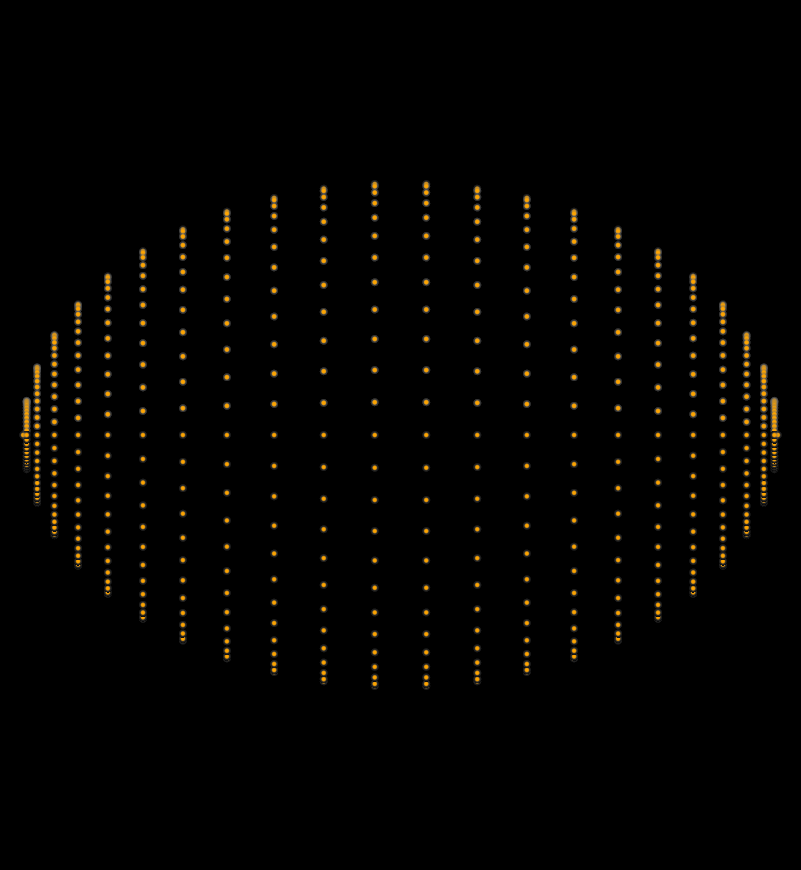

In [2]:
data = vedo.Ellipsoid(axis1=[10, 0, 0], axis2=[0, 20, 0], axis3=[0, 0, 30], pos=[0,0,0])
viewer = napari.Viewer(ndisplay=3)
viewer.add_points(data.vertices, size=0.5, face_color='orange', name='Raw')
napari.utils.nbscreenshot(viewer, canvas_only=True)

## Spherical harmonics

Now we use the `SphericalHarmonicsExpander` class to approximate this pointcloud. The important parameter is the `max_degree` parameter. Higher values for this parameter will tell the function to include spherical harmonic functions of higher orders to approximate the pointcloud and arrive at a better estimation. You'll see that the approximation of the ellipsoid becomes better with higher order. We start with a low order to demonstrate the effect:

In [3]:
Expander = approximation.SphericalHarmonicsExpander(max_degree=1)
fitted_points = Expander.fit_expand(data.vertices)
print('Mean distance between input points and fitted points: ', Expander.properties['residuals'].mean())

Mean distance between input points and fitted points:  1.8058123467745765e-06


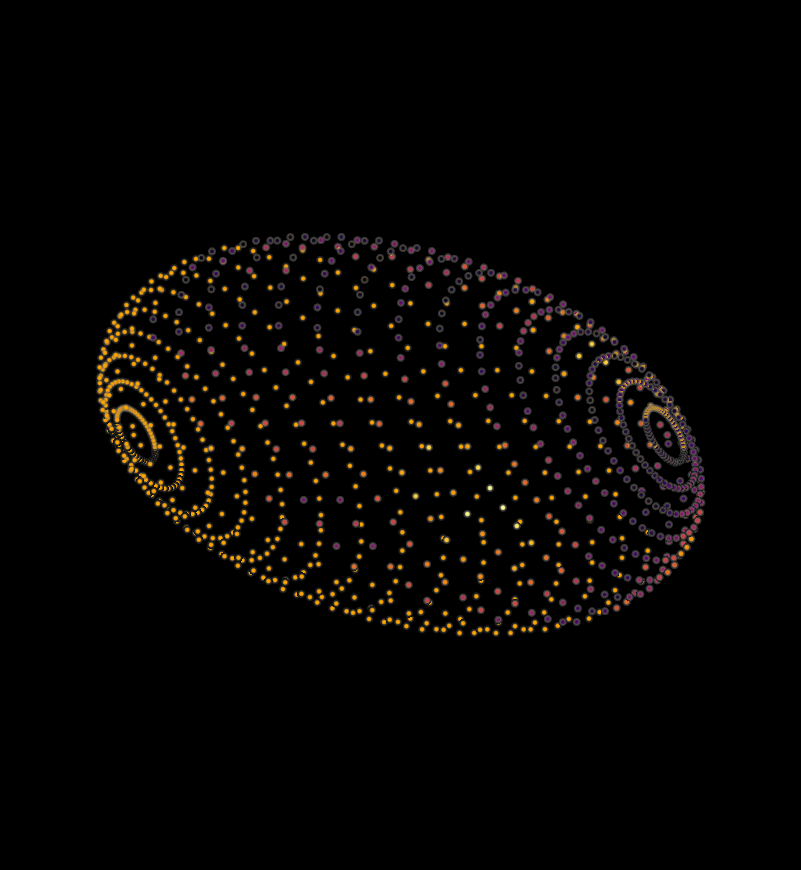

In [4]:
viewer.add_points(fitted_points, size=0.5, features={'residuals': Expander.properties['residuals']},
                  face_color='residuals', name=f'Fitted_order={1}', face_colormap='inferno')

viewer.camera.angles = (0, 45, 45)
napari.utils.nbscreenshot(viewer, canvas_only=True)

Now we use a higher order to approximate the ellipsoid. We can see that the remaining approximation error is less localized and more evenly distributed over the surface of the ellipsoid, which indicates a better overall approximation.

In [5]:
Expander = approximation.SphericalHarmonicsExpander(max_degree=15)
fitted_points = Expander.fit_expand(data.vertices)
print('Mean distance between input points and fitted points: ', Expander.properties['residuals'].mean())

Mean distance between input points and fitted points:  2.2754505054574903e-07


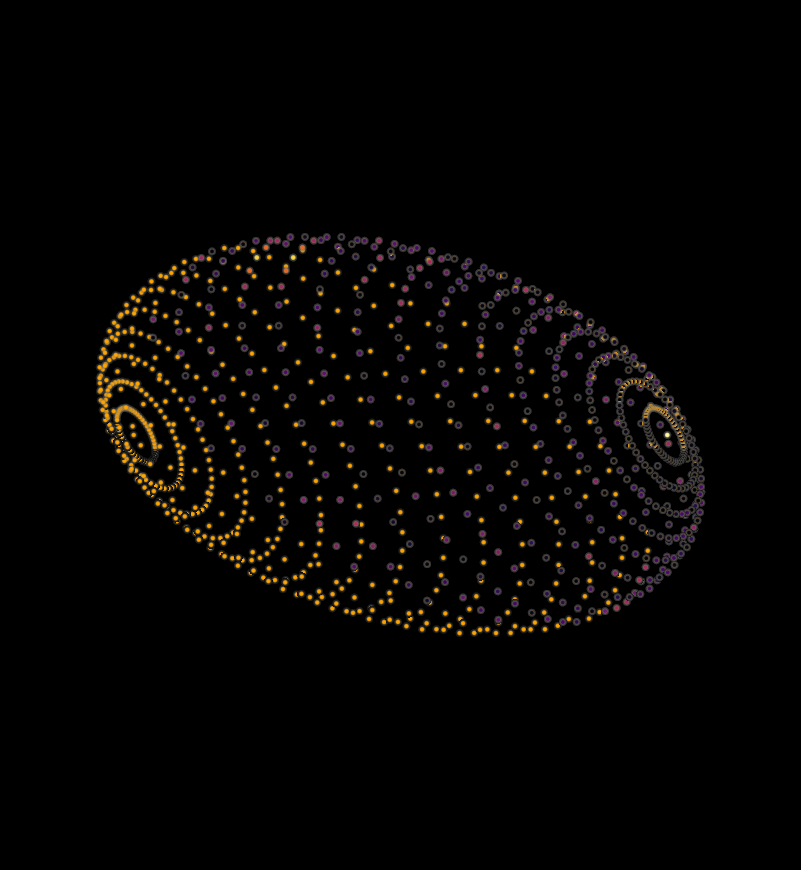

In [6]:
viewer.layers['Fitted_order=1'].visible = False
viewer.add_points(fitted_points, size=0.5, features={'residuals': Expander.properties['residuals']},
                  face_color='residuals', name=f'Fitted_order={15}', face_colormap='inferno')

viewer.camera.angles = (0, 45, 45)
napari.utils.nbscreenshot(viewer, canvas_only=True)

## Quantification

The `SphericalHarmonicsExpander` allows you to extract a few interesting properties. For instance, it can tell you how well the expansion approximates your input:

Text(0, 0.5, 'Occurrences [#]')

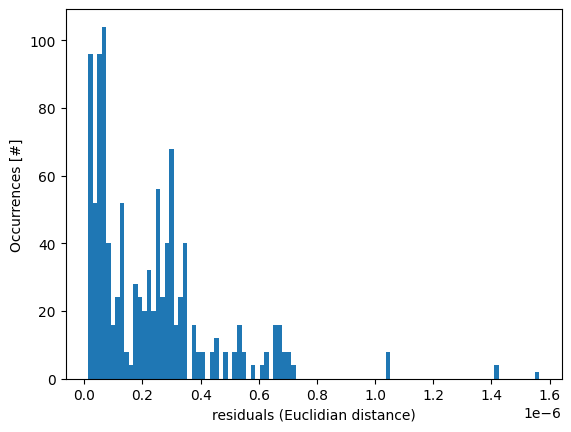

In [7]:
fig, ax = plt.subplots()
ax.hist(Expander.properties['residuals'], bins=100)
ax.set_xlabel('residuals (Euclidian distance)')
ax.set_ylabel('Occurrences [#]')

You can also examine the powerspectrum of the expansion. In essence, it tells you, how much quality each degree $l$ of the expansion adds to the approximation. In the standard case in this implementation, the coordinates $x$, $y$ and $z$ are expanded separately, so a separate powerspectrum is calculated for each of them.

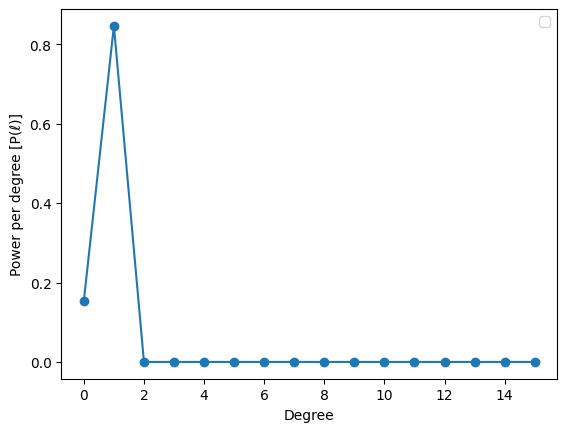

In [8]:
powerspectrum = Expander.properties['power_spectrum']

fig, ax = plt.subplots()
ax.plot(powerspectrum, 'o-')
ax.set_xlabel('Degree')
ax.set_ylabel('Power per degree [P(ℓ)]')
ax.legend()

If you want to evaluate all coefficients, this is a bit more complicated. 

**Mathematical background**: A spherical harmonics approximation (a.k.a. [*expansion*](https://en.wikipedia.org/wiki/Spherical_harmonics#Spherical_harmonics_expansion)) $f(\theta,\phi)$ can be written as a superposition of multiple single spherical harmonics functions $Y_l^m(\theta\phi)$ of different degree and order:

$f(\theta,\phi) = \sum_{l=0}^{\infty} \sum_{m=-l}^{l} f_l^m Y_l^m(\theta\phi)$

whereas the coefficients $f_l^m$ determine how much contribution of which degree $l$ and order $m$ is needed to achieve the best approximation of the input pointcloud. Currently, napari-stress performs the sperhical harmonics expansion separately for the $x$, $y$ and $z$ direction, hence you'll receive three distinct shape spectra:

Text(0.5, 1.0, 'Z')

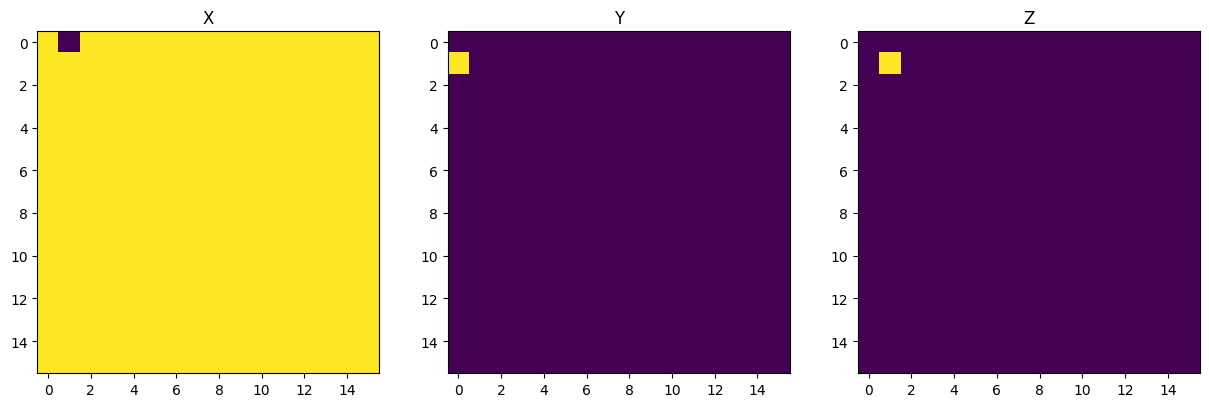

In [9]:
fig, axes = plt.subplots(ncols=3, figsize=(15,5))
axes[0].imshow(Expander.coefficients_[0])
axes[1].imshow(Expander.coefficients_[1])
axes[2].imshow(Expander.coefficients_[2])

axes[0].set_title('X')
axes[1].set_title('Y')
axes[2].set_title('Z')

## Lebedev expansion

The `LebedevExpander` class allows you to approximate a pointcloud with a Lebedev quadrature expansion. The Lebedev quadrature is a method to approximate integrals over the surface of a sphere, and it is particularly useful for spherical harmonics expansions. In more practical terms, the pointcloud is resampled to a pre-defined number if quadrature points for which a number of useful quantities can be more easily inferred, such as the mean curvature on the surface of the object.

In [10]:
expander = approximation.LebedevExpander(
    max_degree=10, n_quadrature_points=590
)
expansion = expander.fit_expand(data.vertices)

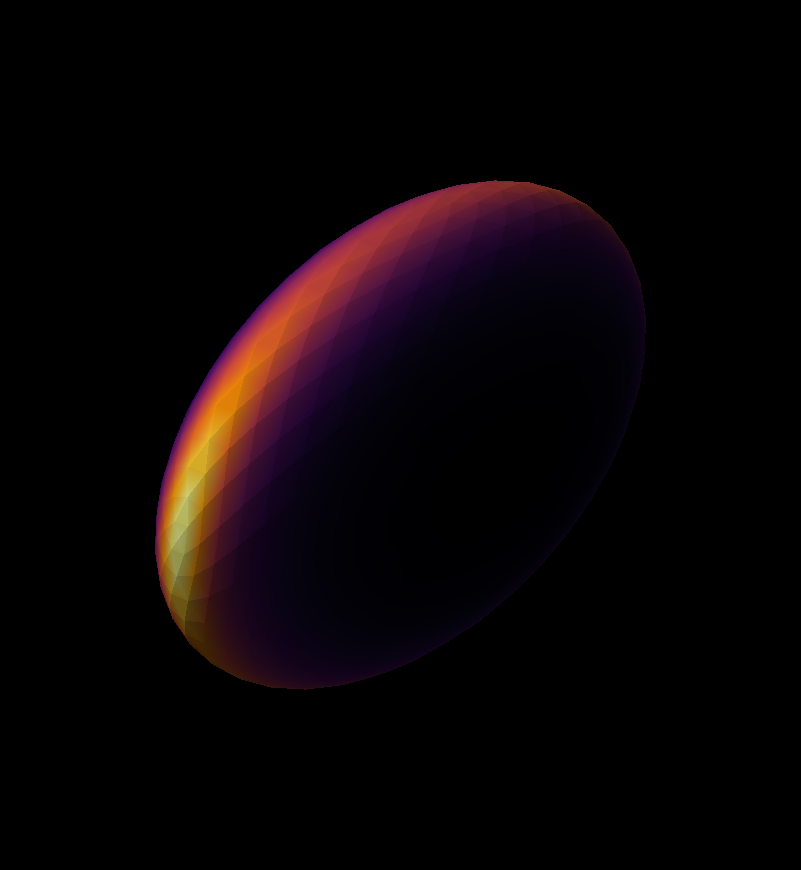

In [11]:
viewer.layers.clear()
features = {
    'mean_curvature': expander.properties['mean_curvature'],
}

surface_modified = (expansion[0], expansion[1], expander.properties['mean_curvature'])
viewer.add_surface(surface_modified, features=features,
                  name='Lebedev_expansion', colormap='inferno')
viewer.camera.angles = (25, -50, 50)

napari.utils.nbscreenshot(viewer, canvas_only=True)